# Building CNN Model for Classification Of Flowers


Dataset URL: https://drive.google.com/file/d/1xkynpL15pt6KT3YSlDimu4A5iRU9qYck/view


In [1]:
import os
from os import path
from pathlib import Path
from matplotlib import pyplot
from typing import Dict, List, Tuple

In [2]:
DATASET_PATH: str = path.join(Path(path.abspath("")).parent, "content", "flowers")
MODEL_PATH: str = path.join(Path(path.abspath("")).parent, "model", "flowers.h5")
directories: Dict[str, str] = {
    "daisy": path.join(DATASET_PATH, "daisy"),
    "dandelion": path.join(DATASET_PATH, "dandelion"),
    "rose": path.join(DATASET_PATH, "rose"),
    "sunflower": path.join(DATASET_PATH, "sunflower"),
    "tulip": path.join(DATASET_PATH, "tulip"),
}

### Data Augumentation


In [3]:
import cv2
import numpy
import pandas
import random
import tensorflow

In [4]:
width, height = 64, 64

training_labels: List[str] = []
training_images: List[str] = []

testing_labels: List[str] = []
testing_images: List[str] = []

In [5]:
def resize_image(image, width=28, height=28):
    dimensions = width, height
    _height, _width = image.shape[:2]
    c = image.shape[2] if len(image.shape) > 2 else 1

    if _height == _width:
        return cv2.resize(image, dimensions, cv2.INTER_AREA)

    difference = _height if _height > _width else _width

    interpolation = cv2.INTER_AREA if difference > (
        width + height) // 2 else cv2.INTER_CUBIC

    x_position = (difference - _width) // 2
    y_position = (difference - _height) // 2

    if len(image.shape) == 2:
        mask = numpy.zeros((difference, difference), dtype=image.dtype)
        mask[y_position:(y_position + _height), x_position:(x_position + _width)] = image[:_height, :_width]

    else:
        mask = numpy.zeros((difference, difference, c), dtype=image.dtype)
        mask[y_position:(y_position + _height), x_position:(x_position + _width), :] = image[:_height, :_width, :]

    return cv2.resize(mask, dimensions, interpolation)

In [6]:
def process_data(flower_type: str, directory: str) -> None:
    images: List[str] = []
    labels: List[str] = []

    for image in os.listdir(directory):
        image_path = path.join(directory, image)
        image_data = cv2.imread(image_path)
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
        image = resize_image(image_data, width, height)

        images.append(image)
        labels.append(flower_type)

    split: int = int(len(images) * 0.9)
    training_labels.extend(labels[:split])
    training_images.extend(images[:split])

    testing_labels.extend(labels[split:])
    testing_images.extend(images[split:])

In [7]:
for flower_type, directory in directories.items():
    process_data(flower_type, directory)

In [8]:
training_data = numpy.array(training_images)
testing_data = numpy.array(testing_images)

training_data = training_data.astype("float32") / 255.0
testing_data = testing_data.astype("float32") / 255.0

label_dummies = pandas.get_dummies(training_labels)
training_labels = label_dummies.values

label_dummies = pandas.get_dummies(testing_labels)
testing_labels = label_dummies.values

In [9]:
numpy.random.seed(42)
random.seed(42)

In [10]:
union_list: List[tuple] = list(zip(training_data, training_labels))
random.shuffle(union_list)
training_data, training_labels = zip(*union_list)

training_data, training_labels = numpy.array(training_data), numpy.array(training_labels)

union_list: List[tuple] = list(zip(testing_data, testing_labels))
random.shuffle(union_list)
testing_data, testing_labels = zip(*union_list)

testing_data, testing_labels = numpy.array(testing_data), numpy.array(testing_labels)

### Building the CNN Model


In [16]:
import tensorflow
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, GlobalMaxPooling2D, Activation, Flatten

In [18]:
model: Sequential = Sequential(name="FlowerClassifier")

model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(64, 64, 3), name="Conv2D_01"))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPooling2D_01"))
model.add(Dropout(0.25, name="Dropout_01"))

model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(64, 64, 3), name="Conv2D_02"))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPooling2D_02"))
model.add(Dropout(0.25, name="Dropout_02"))
model.add(Flatten(name="Flatten_02"))

model.add(Dense(300, activation="relu", name="Dense_Relu_01"))
model.add(Dense(150, activation="relu", name="Dense_Relu_02"))
model.add(Dense(5, activation="softmax", name="Dense_SoftMax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "FlowerClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 MaxPooling2D_01 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 Dropout_01 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 MaxPooling2D_02 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 Dropout_02 (Dropout)        (None, 14, 14, 64)   

In [20]:
model.fit(training_data, training_labels, steps_per_epoch=len(training_data), epochs=20, verbose=1, use_multiprocessing=True)
model.save(MODEL_PATH)

Epoch 1/20
3882/3882 [==============================] - 176s 45ms/step - loss: 0.7341 - accuracy: 0.7236
Epoch 2/20
3882/3882 [==============================] - 169s 44ms/step - loss: 0.6706 - accuracy: 0.7509
Epoch 3/20
3882/3882 [==============================] - 169s 44ms/step - loss: 0.5860 - accuracy: 0.7803
Epoch 4/20
3882/3882 [==============================] - 197s 51ms/step - loss: 0.5227 - accuracy: 0.8120
Epoch 5/20
3882/3882 [==============================] - 155s 40ms/step - loss: 0.4413 - accuracy: 0.8380
Epoch 6/20
3882/3882 [==============================] - 150s 39ms/step - loss: 0.4245 - accuracy: 0.8454
Epoch 7/20
3882/3882 [==============================] - 156s 40ms/step - loss: 0.3449 - accuracy: 0.8776
Epoch 8/20
3882/3882 [==============================] - 152s 39ms/step - loss: 0.3204 - accuracy: 0.8854
Epoch 9/20
3882/3882 [==============================] - 195s 50ms/step - loss: 0.2988 - accuracy: 0.9057
Epoch 10/20
3882/3882 [==============================] 

### Testing model

In [21]:
from tensorflow import keras
from keras.utils import load_img, img_to_array

model: Sequential = keras.models.load_model(MODEL_PATH)

In [22]:
result: List[bool] = []

for index in range(len(testing_data)):
    actual = testing_labels[index].argmax()

    image = numpy.expand_dims(testing_data[index], axis=0)
    predicted = numpy.argmax(model.predict(image, verbose=0, use_multiprocessing=True))

    result.append(actual == predicted)

In [23]:
success = round((result.count(True) / len(result)) * 100, 2)
failure = round((result.count(False) / len(result)) * 100, 2)

print(f"Success %: {success}, Failiure %: {failure}")

Success %: 72.38, Failiure %: 27.62


tulip
1/1 [==============================] - 0s 46ms/step
tulip


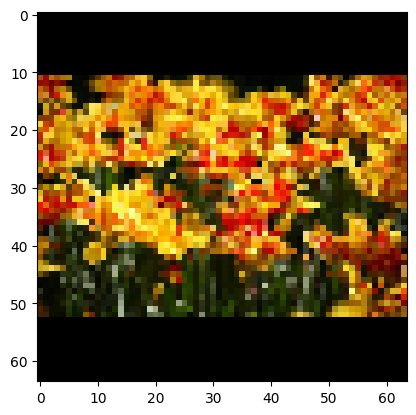

In [24]:
index = random.randint(0, len(testing_data) - 1)
image = numpy.expand_dims(testing_data[index], axis=0)
label = testing_labels[index]
print(['daisy', 'dandelions', 'rose', 'sunflower', 'tulip'][label.argmax()])
print(['daisy', 'dandelions', 'rose', 'sunflower', 'tulip'][numpy.argmax(model.predict(image))])
pyplot.imshow(testing_data[index])